In [1]:
# 训练导入模块
from PIL import Image
import os
import sys
import numpy as np
import time
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# 数据集解压模块
import gzip
import struct

In [2]:
# 是否重新训练模型
'''
注意这个是用来防止反复每次跑代码反复训练的，第一次跑时改成True
'''
is_retrain = False

## 模型


In [3]:
def load_images(filename):
    with gzip.open(filename, 'rb') as f:
        # 读取魔术数和尺寸
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        # 读取图像数据
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def load_labels(filename):
    with gzip.open(filename, 'rb') as f:
        # 读取魔术数和标签数量
        magic, num = struct.unpack(">II", f.read(8))
        # 读取标签
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# 加载训练集
train_images = load_images(r'E:\ipynb\project\cv_exp_mnist\train-images-idx3-ubyte.gz')
train_labels = load_labels(r'E:\ipynb\project\cv_exp_mnist\train-labels-idx1-ubyte.gz')

# 加载测试集
test_images = load_images(r'E:\ipynb\project\cv_exp_mnist\t10k-images-idx3-ubyte.gz')
test_labels = load_labels(r'E:\ipynb\project\cv_exp_mnist\t10k-labels-idx1-ubyte.gz')

# 输出数据集的形状
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [4]:
def img2vector4qt(imgFile):
    #print(“in img2vector func--para:{}”. format(imgFile))
    img = Image.open(imgFile).convert('L')
    img_arr = np.array(img,'i')                         #16像素*16像素的灰度图
    img_normalization = np.round(img_arr /255)          #对灰度值进行归一化处理
    img_arr2=np.reshape(img_normalization,(1,-1))       #1*25的向量
    return img_arr2

In [5]:
# 假设已经从 .idx 文件中读取了 train_images (num_samples, 28, 28) 和 train_labels (num_samples, )
# 需要先调整图像大小为 16x16，然后将它们展平为 1x256 的向量。

# 步骤二：定义函数将 28x28 图像转换成 16x16 的灰度图并展平为 1x256 的向量
def img2vector(img):
    # 调整大小到 16x16 并转换为灰度
    img_resized = Image.fromarray(img).resize((16, 16)).convert('L')
    img_arr = np.array(img_resized)
    # 归一化处理
    img_normalized = np.round(img_arr / 255)
    # 展平成 1x256 的向量
    img_vector = img_normalized.reshape(1, -1)
    return img_vector

# 步骤三：将所有图像转化为向量并存储标签
def prepare_data(images, labels):
    num_samples = images.shape[0]
    dataMat = np.zeros((num_samples, 256))  # 存储每个图像的 1x256 向量
    dataLabel = []
    for i in range(num_samples):
        img_vector = img2vector(images[i])
        dataMat[i, :] = img_vector  # 保存向量化后的图像
        dataLabel.append(labels[i])  # 存储对应标签
    return dataMat, dataLabel

# 步骤四：创建 SVM 模型
def create_svm(dataMat,dataLabel,path,decision='ovr') :
    clf=svm.SVC(decision_function_shape=decision)
    rf =clf.fit(dataMat,dataLabel)
    joblib.dump(rf,path) # 存储模型
    return clf


In [6]:
# train
print('正在运行模型，请稍等...')
    
# 将数据准备为 SVM 可接受的格式
dataMat, dataLabel = prepare_data(train_images, train_labels)
    
# 存储模型
model_path = r'E:\ipynb\project\cv_exp_mnist\svm.model'
if os.path.exists(model_path) is False or is_retrain:
    create_svm(dataMat, dataLabel, model_path, decision='ovr')
    
print('模型训练存储完成')

正在运行模型，请稍等...
模型训练存储完成


## 测试

In [7]:
path= sys.path[0]
model_path=os.path.join(path,r'E:\ipynb\project\cv_exp_mnist\svm.model')
# 加载测试集数据
path=sys.path[0]
tbasePath = test_images
tst = time.process_time()
#加载模型
clf = joblib.load(model_path)
testPath = tbasePath

In [8]:
# 将数据转化为图像矩阵和标签
tdataMat,tdataLabel = prepare_data(test_images,test_labels)
print("测试集数据维度为:{0}， 标签数量: {1}".format(tdataMat.shape,len(tdataLabel)))

测试集数据维度为:(10000, 256)， 标签数量: 10000


In [9]:
def print_accuracy(clf, tdataMat, tdataLabel):
    score_st=time.process_time()
    score = clf.score(tdataMat,tdataLabel)
    score_et=time.process_time()
    print("计算准确率花费 {:.6f}秒.".format(score_et - score_st))
    print("准确率:{:.6f}.".format(score))
    print("错误率:{:.6f}.".format((1 - score)))
    tet = time.process_time()
    print("测试总耗时{:.6f}秒.".format(tet - tst))

In [10]:
def plot_roc_auc(clf, tdataMat, tdataLabel):
    # 计算模型的预测概率（使用 decision_function 或 predict_proba）
    y_score = clf.decision_function(tdataMat)  # 或 clf.predict_proba(tdataMat)[:, 1]
    
    # 对标签进行二值化处理
    tdataLabel_bin = label_binarize(tdataLabel, classes=np.arange(10))  # 10 类标签，调整为你的类别数
    
    # 计算 ROC 曲线
    fpr, tpr, thresholds = roc_curve(tdataLabel_bin.ravel(), y_score.ravel())
    
    # 计算 AUC
    roc_auc = auc(fpr, tpr)
    
    # 绘制 ROC 曲线
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [18]:
def plot_confusion_matrix_with_values(clf, tdataMat, tdataLabel):
    # 获取预测标签
    y_pred = clf.predict(tdataMat)
    
    # 计算混淆矩阵
    cm = confusion_matrix(tdataLabel, y_pred)
    
    # 绘制混淆矩阵
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(10)  # 假设有 10 类
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # 在每个格子中显示数字
    thresh = cm.max() / 2  # 设置阈值，较大值时显示白色数字
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]}', ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.show()

计算准确率花费 7.953125秒.
准确率:0.967600.
错误率:0.032400.
测试总耗时44.828125秒.


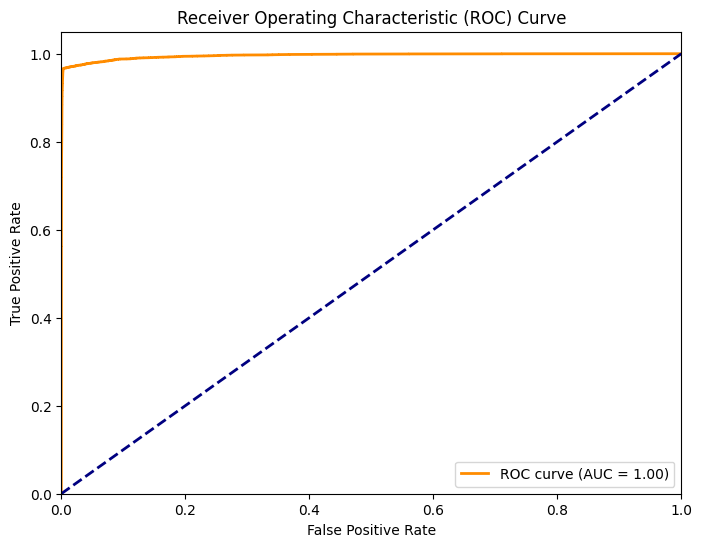

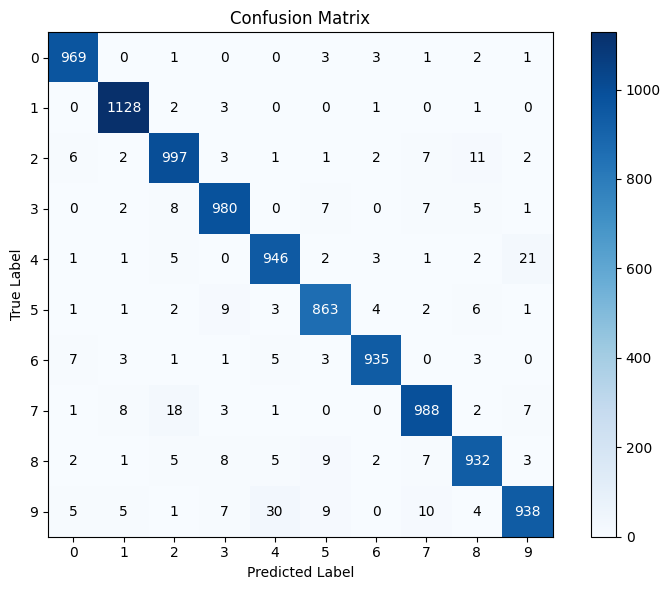

In [19]:
if is_retrain:
    print_accuracy(clf, tdataMat, tdataLabel)
    plot_roc_auc(clf, tdataMat, tdataLabel)
    plot_confusion_matrix_with_values(clf, tdataMat, tdataLabel)

## Qt

In [13]:
from PyQt5.QtWidgets import QFileDialog
from PyQt5 import QtCore,QtGui, QtWidgets
from PyQt5.QtWidgets import *

In [14]:
class Ui_Dialog(object):
    def setupUi(self, Dialog):
        Dialog.setObjectName("Dialog")
        # Set window size
        Dialog.resize(645, 475)
        # Set "Open Image" button
        self.pushButton = QtWidgets.QPushButton(Dialog)
        self.pushButton.setGeometry(QtCore.QRect(230, 340, 141, 41))
        self.pushButton.setAutoDefault(False)
        self.pushButton.setObjectName("pushButton")
        # Set label for displaying images
        self.label = QtWidgets.QLabel(Dialog)
        self.label.setGeometry(QtCore.QRect(220, 50, 191, 221))
        self.label.setWordWrap(False)
        self.label.setObjectName("label")
        # Set text edit area
        self.textEdit = QtWidgets.QTextEdit(Dialog)
        self.textEdit.setGeometry(QtCore.QRect(220, 280, 191, 41))
        self.textEdit.setObjectName("textEdit")

        self.retranslateUi(Dialog)
        QtCore.QMetaObject.connectSlotsByName(Dialog)

    def retranslateUi(self, Dialog):
        _translate = QtCore.QCoreApplication.translate
        Dialog.setWindowTitle(_translate("Dialog", "手写体识别"))
        self.pushButton.setText(_translate("Dialog", "打开图像"))
        self.label.setText(_translate("Dialog", "显示图像"))

In [15]:
class MyWindow(QtWidgets.QMainWindow, Ui_Dialog):
    # Initialize data
    def __init__(self, parent=None):
        super(MyWindow, self).__init__(parent)
        self.setupUi(self)
        self.pushButton.clicked.connect(self.openImage)  # Click event to open image

    def openImage(self):
        # When "Open Image" button is clicked
        imgName, imgType = QFileDialog.getOpenFileName(self, "打开图像", "img_test")
        # Get image width and height, display on dialog
        png = QtGui.QPixmap(imgName).scaled(self.label.width(), self.label.height())
        self.label.setPixmap(png)
        self.textEdit.setText(imgName)
        # Load SVM model and predict the selected image's category
        path = sys.path[0]
        model_path = os.path.join(path, r'E:\ipynb\project\cv_exp_mnist\svm.model')
        clf_joblib = joblib.load(model_path)
        dataMat = img2vector4qt(imgName)
        preResult = str(clf_joblib.predict(dataMat))
        # Display processing results in text box
        self.textEdit.setReadOnly(True)
        self.textEdit.setStyleSheet("color:red")
        self.textEdit.setAlignment(QtCore.Qt.AlignHCenter | QtCore.Qt.AlignVCenter)
        self.textEdit.setFontPointSize(9)
        self.textEdit.setText("预测结果是:")
        self.textEdit.append(preResult[1])

In [21]:
%tb
app = QApplication.instance()
if app is None:
    app= QApplication(sys.argv)
myWin = MyWindow()
myWin.show()
sys.exit(app.exec_())

SystemExit: 0

SystemExit: 0